In [37]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.0501,
	"longitude": -114.0853,
	"start_date": "2021-01-01",
	"end_date": "2024-12-31",
	"hourly": "soil_temperature_0_to_7cm",
	"daily": ["temperature_2m_mean", "daylight_duration", "rain_sum", "snowfall_sum", "wind_speed_10m_max", "shortwave_radiation_sum"],
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_soil_temperature_0_to_7cm = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_daylight_duration = daily.Variables(1).ValuesAsNumpy()
daily_rain_sum = daily.Variables(2).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(3).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(4).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(5).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

Coordinates 51.07205581665039°N -114.03227233886719°E
Elevation 1043.0 m asl
Timezone b'America/Edmonton' b'GMT-7'
Timezone difference to GMT+0 -25200 s
                           date  soil_temperature_0_to_7cm
0     2021-01-01 07:00:00+00:00                     -1.251
1     2021-01-01 08:00:00+00:00                     -1.251
2     2021-01-01 09:00:00+00:00                     -1.251
3     2021-01-01 10:00:00+00:00                     -1.251
4     2021-01-01 11:00:00+00:00                     -1.251
...                         ...                        ...
35059 2025-01-01 02:00:00+00:00                     -6.401
35060 2025-01-01 03:00:00+00:00                     -6.601
35061 2025-01-01 04:00:00+00:00                     -6.751
35062 2025-01-01 05:00:00+00:00                     -6.951
35063 2025-01-01 06:00:00+00:00                     -7.251

[35064 rows x 2 columns]
                          date  temperature_2m_mean  daylight_duration  \
0    2021-01-01 07:00:00+00:00         

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skforecast.recursive import ForecasterRecursive
from skforecast.recursive import ForecasterRecursiveMultiSeries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (10,5)
daily_dataframe['date'] = pd.to_datetime(daily_dataframe['date'], format='%Y-%m-%d')
daily_dataframe = daily_dataframe.set_index("date")
daily_dataframe = daily_dataframe.asfreq('D')
df = daily_dataframe.sort_index()
df.head()

,temperature_2m_mean,daylight_duration,rain_sum,snowfall_sum,wind_speed_10m_max,shortwave_radiation_sum
date,,,,,,
2021-01-01 07:00:00+00:00,-3.040584,28854.302734,0.0,0.0,18.581022,3.72
2021-01-02 07:00:00+00:00,0.034417,28927.406250,0.0,0.0,39.127541,4.49
2021-01-03 07:00:00+00:00,0.474000,29005.925781,0.1,0.0,34.949680,4.91
2021-01-04 07:00:00+00:00,-2.207250,29089.761719,0.0,0.0,24.522316,4.36
2021-01-05 07:00:00+00:00,-0.444750,29178.787109,0.0,0.7,16.595179,4.93


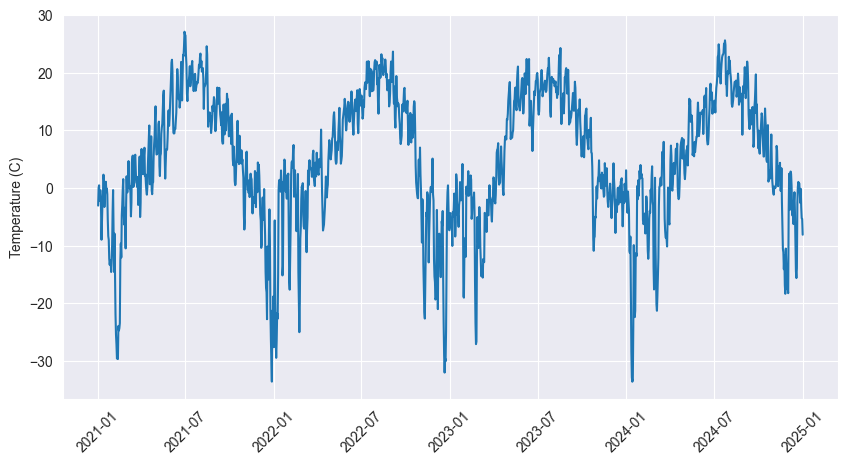

In [39]:
plt.plot(df["temperature_2m_mean"])
plt.ylabel("Temperature (C)")
plt.xticks(rotation = 45)
plt.show()

In [60]:
steps = 20
data_train = df.iloc[:-steps, :]
data_test  = df.iloc[-steps:, :]

In [61]:
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 4
             )

forecaster.fit(
    y    = data_train['temperature_2m_mean'],
    exog = data_train.drop("temperature_2m_mean", axis = "columns")
)
print(forecaster)

ForecasterRecursive 
Regressor: RandomForestRegressor 
Lags: [1 2 3 4] 
Window features: None 
Window size: 4 
Exogenous included: True 
Exogenous names: 
    daylight_duration, rain_sum, snowfall_sum, wind_speed_10m_max,
    shortwave_radiation_sum 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 07:00:00+0000', tz='UTC'), Timestamp('2024-12-11 07:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kw

In [67]:
# Predict
# ==============================================================================
predictions = forecaster.predict(
                  steps = steps,
                  exog = data_test.drop("temperature_2m_mean", axis = "columns")
              )

predictions.head(100)

2024-12-12 07:00:00+00:00    -3.026396
2024-12-13 07:00:00+00:00    -2.397396
2024-12-14 07:00:00+00:00    -0.724208
2024-12-15 07:00:00+00:00    -0.889396
2024-12-16 07:00:00+00:00    -2.607583
2024-12-17 07:00:00+00:00    -5.009083
2024-12-18 07:00:00+00:00   -11.712625
2024-12-19 07:00:00+00:00   -13.457834
2024-12-20 07:00:00+00:00    -5.988979
2024-12-21 07:00:00+00:00    -1.410146
2024-12-22 07:00:00+00:00    -0.120146
2024-12-23 07:00:00+00:00    -0.730063
2024-12-24 07:00:00+00:00    -0.342813
2024-12-25 07:00:00+00:00    -0.639771
2024-12-26 07:00:00+00:00    -0.473563
2024-12-27 07:00:00+00:00    -1.196375
2024-12-28 07:00:00+00:00    -2.650354
2024-12-29 07:00:00+00:00    -4.407208
2024-12-30 07:00:00+00:00   -10.507480
2024-12-31 07:00:00+00:00   -14.659834
Freq: D, Name: pred, dtype: float64

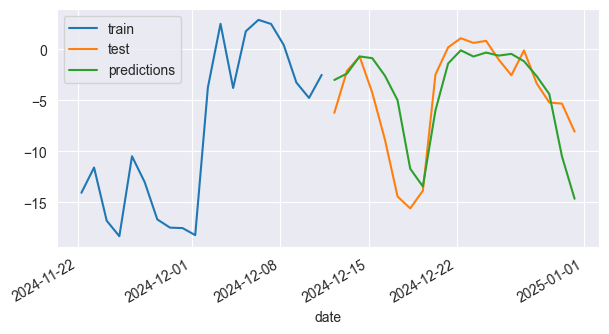

In [63]:
fig, ax=plt.subplots(figsize=(7, 3.5))
data_train['temperature_2m_mean'].iloc[-20:].plot(ax=ax, label='train')
data_test['temperature_2m_mean'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();